# Star Formation Histories of the MW Dwarf Galaxies

### This notebook analyzes the SFHs of the MW Dwarf Galaxies in Galacticus bestfit file. We create two types of plots. $\tau_{90}$ vs. $\tau_{50}$ and SFH (stellar mass fraction at time t ). $\tau_{90}$ is the time taken to gain 90% of the stellar mass we see at z=0, and $\tau_{50}$ is the time taken to gain 50% of the stellar mass we see at z=0. This is a plot that appeared first in Weisz et al. 2019.

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import h5py
from scipy import stats
from scipy.optimize import curve_fit
from astropy.io import fits
from astropy.table import Table
import astropy.io.ascii
import scipy
from matplotlib.patches import Rectangle

In [2]:
#observed SFHs
d=open('/home/sachiwee/simulations/MW/50M/d.4096/sfh_obs.txt','r')
dat=d.read()
data=astropy.io.ascii.read(dat, delimiter='')
print(data)

FileNotFoundError: [Errno 2] No such file or directory: '/home/sachiwee/simulations/MW/50M/d.4096/sfh_obs.txt'

In [ ]:
# Setting up the SFHs of observations Weisz+2014

t_obs=[10.1,10.05,10.0,9.95,9.9,9.85,9.75,9.7,9.6,9.55,9.5,9.45,9.4,9.35,9.3,9.25,9.2,9.15,9.1,9.05,9.0,8.95,8.9,8.85,8.8,8.75,8.7,8.6,8.5,8.4,8.3,8.2,8.1,8.0,7.9,7.8,7.7,7.8,7.7,7.6,7.5,7.4,7.3,7.2,7.1,7.0,6.9,6.8,6.7,6.6]
tobs=[10.1,10.05,10.0,9.55,9.5,9.45,9.4,9.35,9.3,9.25,9.2,9.15,9.1,9.05,9.0,8.95,8.9,8.85,8.8,8.75,8.7,8.6,8.5,8.4,8.3,8.2,8.1,8.0,7.9,7.8,7.7,7.8,7.7,7.6,7.5,7.4,7.3,7.2,7.1,7.0,6.9,6.8,6.7,6.6]
sfh_obs=np.zeros((len(data['f10.1']),1,len(t_obs)))

sfh_obs_84=np.zeros((len(data['f10.1']),1,len(t_obs)))
sfh_obs_16=np.zeros((len(data['f10.1']),1,len(t_obs)))

sfh_obs_84t=np.zeros((len(data['f10.1']),1,len(tobs)))
sfh_obs_16t=np.zeros((len(data['f10.1']),1,len(tobs)))
for i in range(len(data['f10.1'])):
    if(i==1 or i==6 or i==7 or i==8):
        for t in range(len(t_obs)):
            sfh_obs[i][0][t]=data['f%s'%str(t_obs[t])][i]
            sfh_obs_84[i][0][t]=data['f%s'%str(t_obs[t])][i]+data['Urf%s'%str(t_obs[t])][i]
            sfh_obs_16[i][0][t]=data['f%s'%str(t_obs[t])][i]-data['Lrf%s'%str(t_obs[t])][i]
            
            
for i in range(len(tobs)):
    if(i==1 or i==6 or i==7 or i==8):
        for t in range(len(tobs)):
            sfh_obs_84t[i][0][t]=data['f%s'%str(tobs[t])][i]+data['Utf%s'%str(tobs[t])][i]
            sfh_obs_16t[i][0][t]=data['f%s'%str(tobs[t])][i]-data['Ltf%s'%str(tobs[t])][i]

#observed look back time Gyrs
lbt_obs=[((10**i)/(10**9)) for i in t_obs]
lbtobs=[((10**i)/(10**9)) for i in tobs]


In [ ]:
text=np.genfromtxt('/home/sachiwee/simulations/MW/50M/d.4096/SFHsats.txt',names=True,delimiter='')
hlr_obs=np.array(text['hlr_pc'])


In [ ]:
# calculating tau_50 and tau_90 for observations
t50_obs=[(10**i)/(10**9) for i in text['t50_logYr']]
t90_obs=[(10**i)/(10**9) for i in text['t90_logYr']]

In [ ]:
#***********************Galacticus model***************************************************************************
name='/media/sachiwee/ArmorATD/MW_MAC/MWoutputs_6_11_22/MW_blitz_z_cV160_151_e1.7_0.3_vF25_cooling19_coldmode_spnv_starvesatsF_ram100_tidal01_ode_sfh390_vdis_indexShift_test2.hdf5'
# name='/media/sachiwee/ArmorATD/MW_MAC/MWoutputs/vFcooling/vFcooling/MW_blitz_z_cV160_151_e1.7_0.3_vF20_cooling18_coldmode_spnv_starvesatsF_ram100_tidal01_sfr390.hdf5'
#Reading in the file
f=h5py.File(name,'r')

#Read the total stellar mass
stellar_mass2=np.array(f['Outputs']['Output1']['nodeData']['massStellarTotal'])
# Read stellar mass of the disk and the spheroid
stellar_mass1=np.array(f['Outputs']['Output1']['nodeData']['spheroidMassStellar'][:]+f['Outputs']['Output1']['nodeData']['diskMassStellar'][:])

#Read dark matter mass
mass_dm=f['Outputs']['Output1']['nodeData']['basicMass'][:]

#Find the highest mass halo
l=np.argmax(mass_dm)

#Read in x,y,z positions of halos
x=f['Outputs']['Output1']['nodeData']['positionPositionX'][:]-f['Outputs']['Output1']['nodeData']['positionPositionX'][:][l]
y=f['Outputs']['Output1']['nodeData']['positionPositionY'][:]-f['Outputs']['Output1']['nodeData']['positionPositionY'][:][l]
z=f['Outputs']['Output1']['nodeData']['positionPositionZ'][:]-f['Outputs']['Output1']['nodeData']['positionPositionZ'][:][l]

#Read in the Luminosity in SDSS g band
Lg=f['Outputs']['Output1']['nodeData']['spheroidLuminositiesStellar:SDSS_g:observed:z0.0000'][:]+f['Outputs']['Output1']['nodeData']['diskLuminositiesStellar:SDSS_g:observed:z0.0000'][:]

#Distance from Earth
d=np.sqrt(x**2.0+y**2.0+z**2.0)

#Calculate absolute g band magnitude
Mg=-2.5*np.log10(Lg)

#Satellite mask within 400kpc
satellite_mask=(d<0.4)&(mass_dm<np.amax(mass_dm))&(Mg>-22)&(Mg<2)
stellar_mass=stellar_mass1[satellite_mask]

#order the satellites based on Mg
order=np.flip(np.argsort(Mg[satellite_mask]))


In [ ]:
#****************Read in star formation histories*******************************************************
sfh=f['starFormationHistories']['Output1']['diskStarFormationHistory'][:][satellite_mask][order]
sfh_sph=f['starFormationHistories']['Output1']['spheroidStarFormationHistory'][:][satellite_mask][order]
sfh_disk=f['starFormationHistories']['Output1']['diskStarFormationHistory'][:][satellite_mask][order]

#Read in time coreesponding to star formation histories
time=f['starFormationHistories']['Output1']['time'][:]

#Read half light radii of halos
hlr=f['Outputs']['Output1']['nodeData']['halfLightRadiusSDSS_g:observed:z0.0000'][:][satellite_mask][order]


#create a mask for halos with stellar mass greater than 0
mask2=(stellar_mass[order]>0) 
#calculate look back time
lt=13.74-time

#close the hdf5 file 
f.close()

In [3]:
# create arrays
sfh_cum=np.zeros((len(hlr[mask2]),1,len(time)))
sfh_mass_t=np.zeros((len(hlr[mask2]),1,len(time)))



NameError: name 'hlr' is not defined

In [4]:

for sat in range(len(stellar_mass[mask2])):
    area=0
    for t in range(1,len(time)):
        #calculates mass of the components at time t, 
        mass_disk=sfh_disk[mask2][sat][0][t]
        mass_sph=sfh_sph[mask2][sat][0][t]
        
        #compute the cummulative mass at time t
        area=area+mass_disk+mass_sph
        sfh_cum[sat][0][t]=area
            

        

NameError: name 'stellar_mass' is not defined

<IPython.core.display.Javascript object>


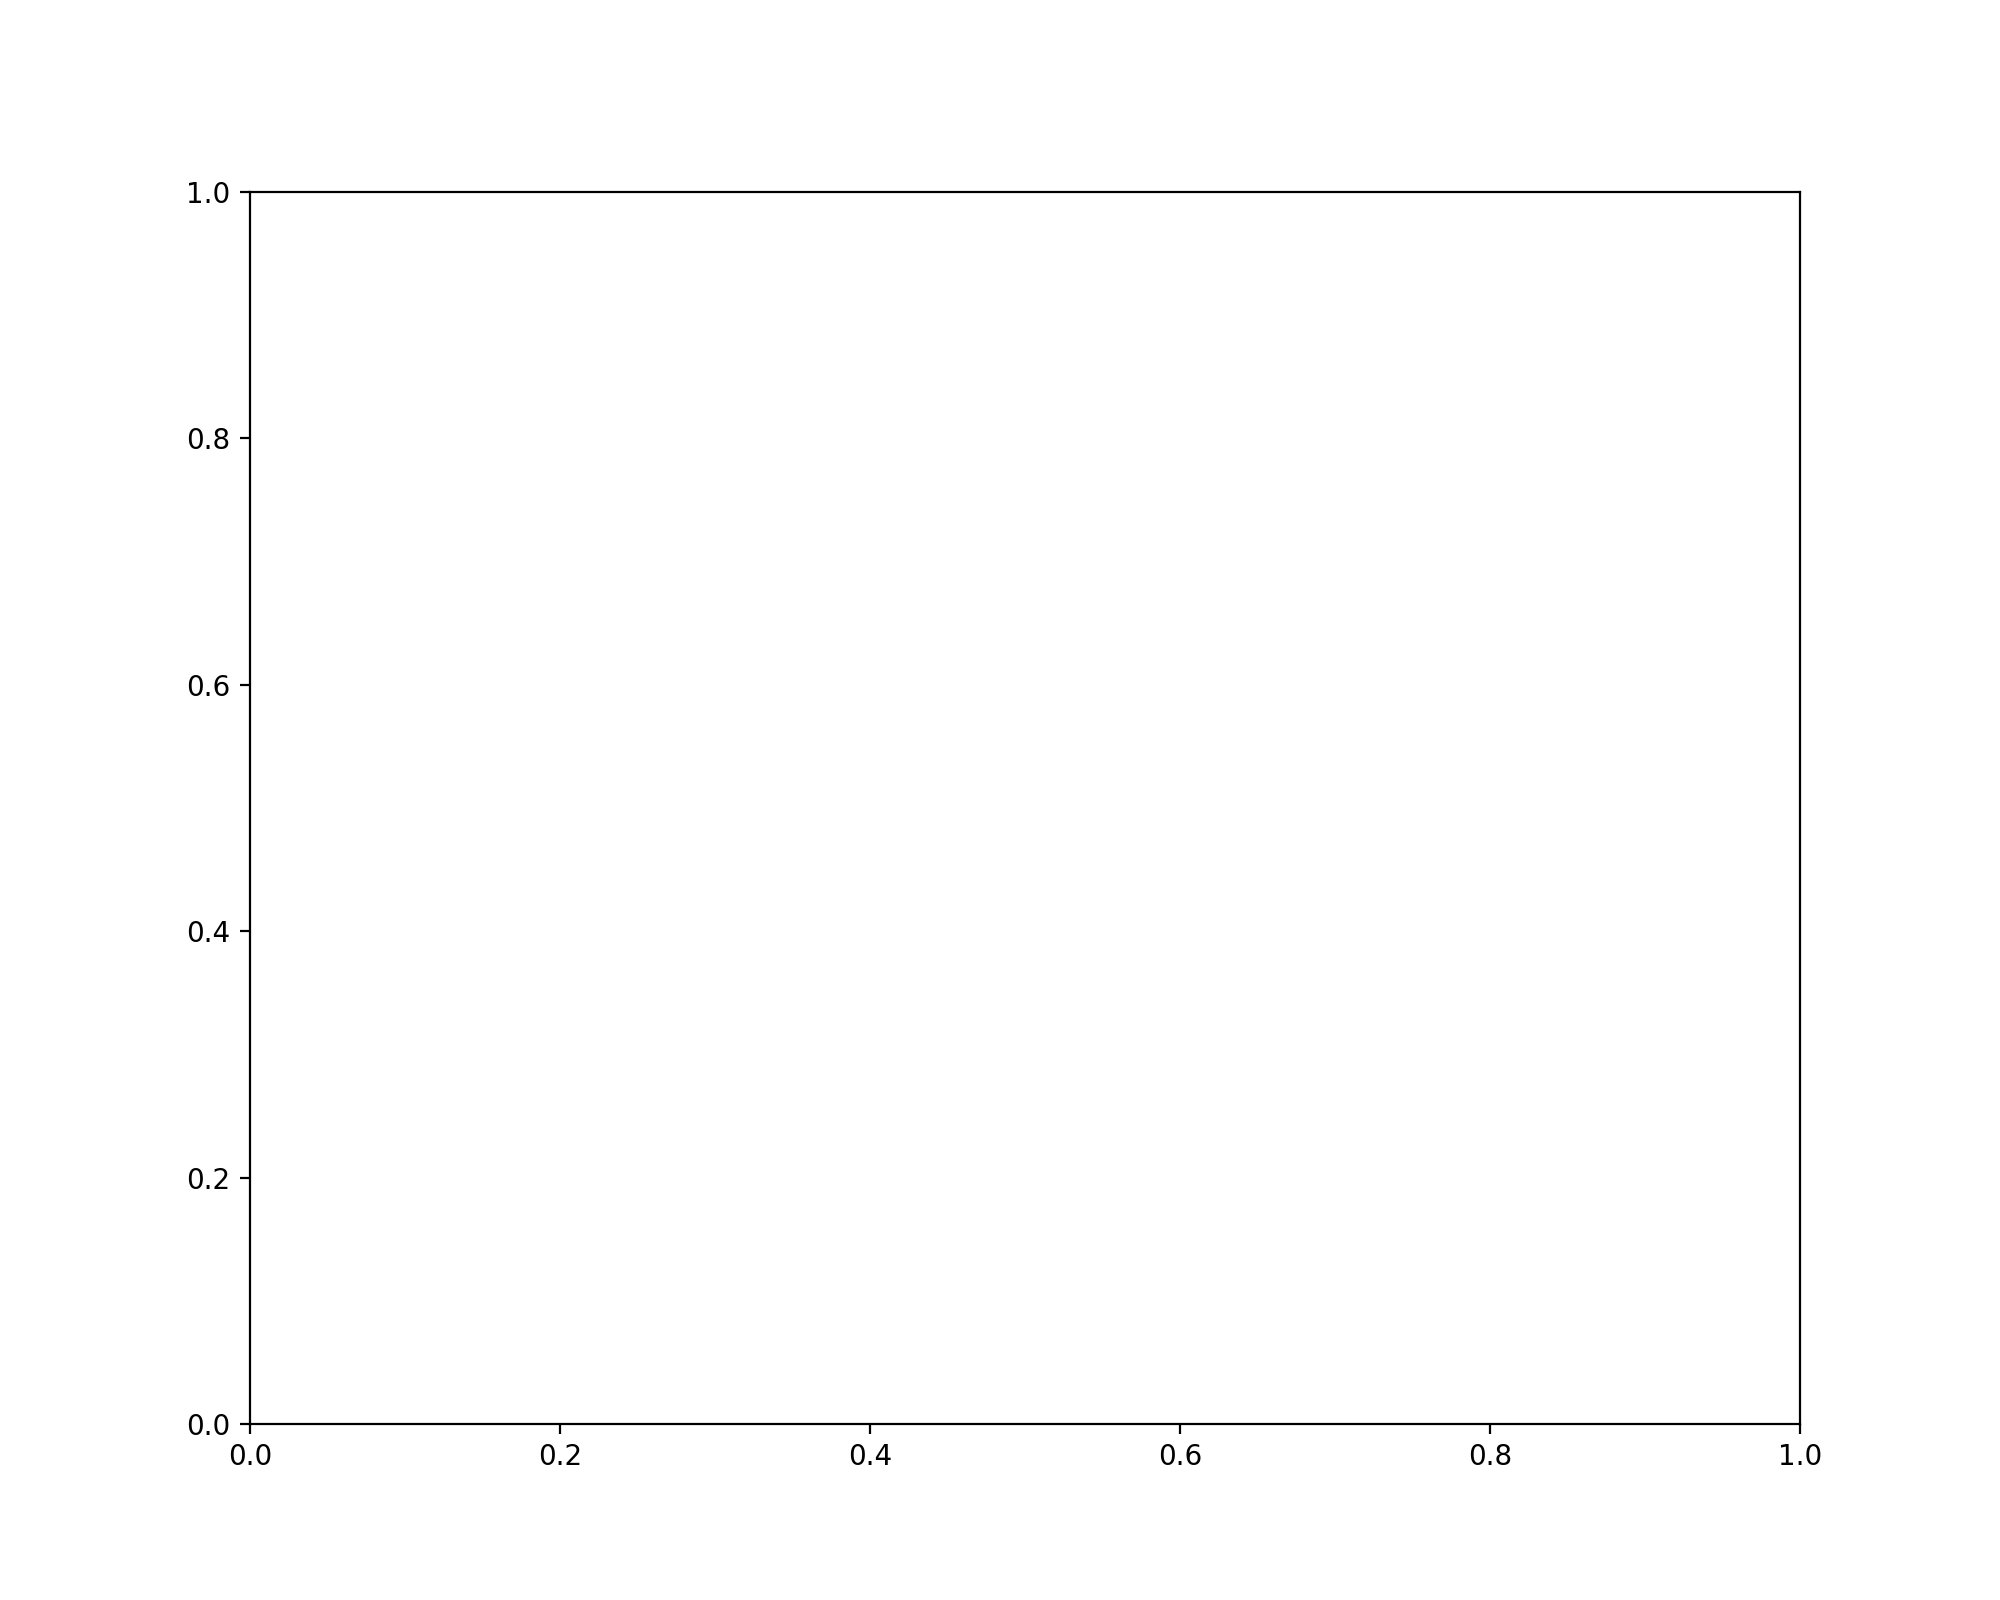

NameError: name 'stellar_mass' is not defined

In [5]:
fig4=plt.figure(figsize=(10,8))
ax4=fig4.add_subplot(111)
for sat in range(len(stellar_mass[mask2])):

    ax4.scatter(lt,sfh_disk[sat][0],c='k',s=5)

ax4.set_yscale('log')
ax4.set_ylabel('$M_{*,disk}/Gyr$',fontsize=15)
ax4.set_xlabel('Look Back Time (Gyrs)',fontsize=15)
# ax5.set_xscale('log')
ax4.invert_xaxis()
ax4.set_ylim(1e2,1.1e10)

<IPython.core.display.Javascript object>


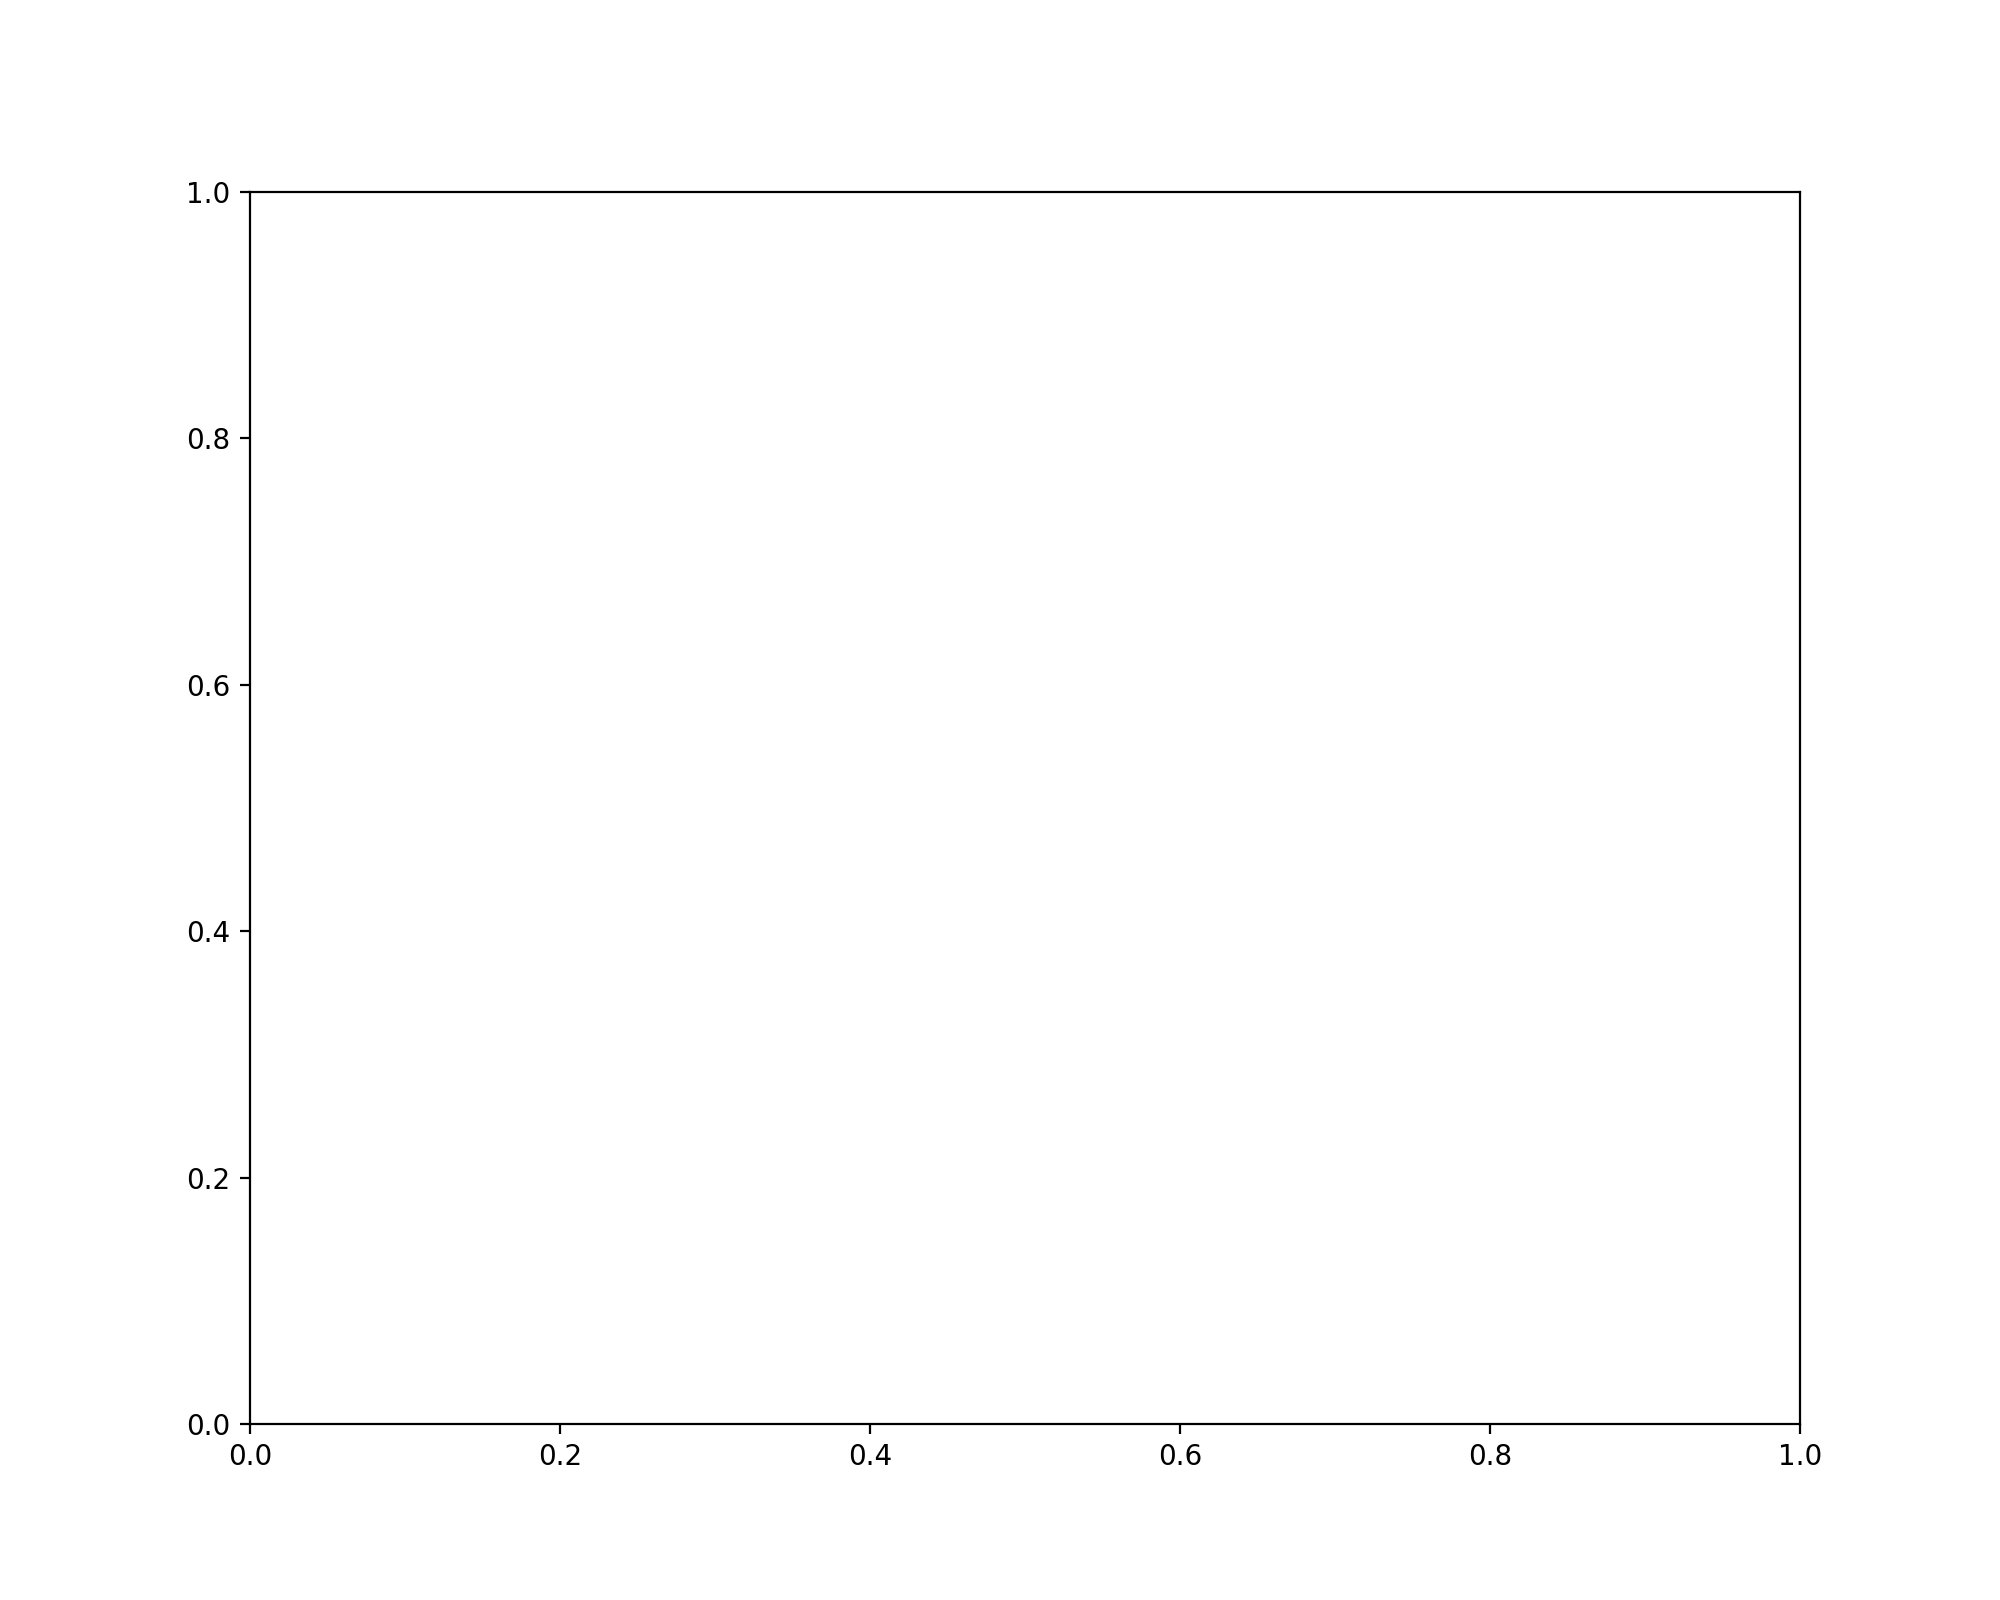

NameError: name 'stellar_mass' is not defined

In [6]:
fig5=plt.figure(figsize=(10,8))
ax5=fig5.add_subplot(111)
for sat in range(len(stellar_mass[mask2])):

    ax5.scatter(stellar_mass[order][mask2][sat],sfh_cum[sat][0][len(lt)-1],c='k',s=5)

ax5.scatter(stellar_mass[order][mask2],stellar_mass[order][mask2],c='r',s=1,label='1:1 $M_*$ (z=0) ')
# plt.scatter(lt,sfh_disk[50][0])
ax5.set_yscale('log')
ax5.set_xscale('log')
ax5.set_ylabel('$M_{*}$(z=0) [from SFH]',fontsize=15)
ax5.set_xlabel('$M_{*}$(z=0) ',fontsize=15)
# ax5.invert_xaxis()
ax5.legend(fontsize=14)
ax5.set_ylim(1e2,1.1e11)
ax5.set_xlim(1e2,1.1e11)
print(sfh_cum[50][0][len(lt)-1]-stellar_mass[order][mask2][50])

In [7]:
#test plot stellar mass vs sfr

In [8]:
#Initialize arrays
t90=np.zeros(len(x[satellite_mask][mask2]))
t50=np.zeros(len(x[satellite_mask][mask2]))

NameError: name 'x' is not defined

In [9]:
#Goes over the cumulative stellar mass over time to find tau 90 and tau 50

for sat in range(len(stellar_mass[mask2])):
        for t in range(len(time)-1):
            stellar_mass_z0=stellar_mass[order][mask2][sat]

            if(sfh_cum[sat][0][t]>=stellar_mass_z0*.90):
                if(t90[sat]==0):

                    t90[sat]=time[t]
                
for sat in range(len(stellar_mass[mask2])):
        for t in range(len(time)-1):
            stellar_mass_z0=stellar_mass[order][mask2][sat]
            if(sfh_cum[sat][0][t]>=stellar_mass_z0*.50):
                if(t50[sat]==0):
#                     print('SAT',sat,time[t])
                    t50[sat]=time[t]


NameError: name 'stellar_mass' is not defined

In [10]:
#mask model data with t50 and t90 >0
msk=(t50>0)& (t90>0)


NameError: name 't50' is not defined

In [11]:
def plot_t90_t50(t50,t90,hlr,Mg):
    '''Plot t 90 vs t90 for all MW satellites  '''
    
    fig=plt.figure(figsize=(9,8))
    ax=fig.add_subplot(111)
    
    fig.patch.set_facecolor('w')
    t50_array=np.arange(0.00,14,0.01)
    tsfh_2=14 + 2*np.log((9/5)*np.exp(-14/2)*np.exp(t50_array/2) - (4/5))
    tsfh_10=14 + 10*np.log((9/5)*np.exp(-14/10)*np.exp(t50_array/10) - (4/5))

    ax.plot(t50_array,1.8*t50_array-11.2,c='k',linewidth=2,zorder=0,label='Constant SFH')
    ax.plot(t50_array,tsfh_2,c='k',linewidth=2,zorder=0,linestyle='-.',label='$\u03C4_{SFH}\,=\,2\,Gyr$')
    ax.plot(t50_array,tsfh_10,c='k',linewidth=2,zorder=0,linestyle='--',label='$\u03C4_{SFH}\,=\,10\,Gyr$')
    
    s1=ax.scatter(13.74-t50[msk],13.74-t90[msk],s=(1e5*hlr[mask2][msk]),cmap='plasma',vmin=-20,vmax=-4,c=Mg[satellite_mask][order][mask2][msk])
    ax.scatter(3,10,s=50,c='lightgrey',edgecolors='k')
    ax.text(3.1,11,'500 pc',fontsize=15)
    
    ax.add_patch(Rectangle((6,3),7.5,3,edgecolor='blue',facecolor='none',lw=2,ls=':'))

    cb1 = fig.colorbar(s1,pad=0.03)
    cb1.set_label('$\mathcal{M}_{V}$', fontsize=25)
    cb1.ax.tick_params(labelsize=15)

    ax.set_xlim(0,14)
    ax.set_ylim(0,14)
    

    ax.set_ylabel('$\u03C4_{90}\;[Gyr\;ago]$',fontsize=20)
    ax.set_xlabel('$\u03C4_{50}\;[Gyr\;ago]$',fontsize=20)
    leg=ax.legend(fontsize=18,loc='upper left',markerscale=0.01)
    plt.setp(leg.get_texts(), color='w')
    frame = leg.get_frame()

    ax.set_xticks(np.arange(0,14,3))
    ax.set_yticks(np.arange(0,14,3))
    ax.invert_xaxis()
    ax.invert_yaxis()
    ax.xaxis.set_tick_params(labelsize=15)
    ax.yaxis.set_tick_params(labelsize=15)
    ax.legend(fontsize=15)


    return fig

In [13]:
def plot_t90_Mv(t50,t90,hlr,Mg):
    '''Plot tau 90 vs tau 50 for all MW satellites  '''
    fig=plt.figure(figsize=(9,8))
    ax=fig.add_subplot(111)

    fig.patch.set_facecolor('w')
    t50_array=np.arange(0.00,14,0.01)
    tsfh_2=14 + 2*np.log((9/5)*np.exp(-14/2)*np.exp(t50_array/2) - (4/5))
    tsfh_10=14 + 10*np.log((9/5)*np.exp(-14/10)*np.exp(t50_array/10) - (4/5))
      
    #plot tau 90 vs tau 50
    s1=ax.scatter(Mg[satellite_mask][order][mask2][msk],13.74-t90[msk],s=(1e5*hlr[mask2][msk]),cmap='viridis',vmin=7,vmax=11,c=np.log10(mass_dm[satellite_mask][order][mask2][msk]))
    ax.scatter(-20,12,s=20,c='lightgrey',edgecolors='k')
    ax.text(-20.2,11.5,'200 pc',fontsize=15)

    cb1 = fig.colorbar(s1,pad=0.03)
    cb1.set_label('$\mathcal{M}_{DM}\;(M_{\odot})$', fontsize=25,rotation=90)
    cb1.ax.tick_params(labelsize=15)

    ax.set_xlim(-24,-2)
    ax.set_ylim(0,14)
    

    ax.set_ylabel('$\u03C4_{90}\;[Gyr\;ago]$',fontsize=20)
    ax.set_xlabel('$M_V$',fontsize=20)
    leg=ax.legend(fontsize=18,loc='upper left',markerscale=0.01)
    plt.setp(leg.get_texts(), color='w')
    frame = leg.get_frame()

    ax.set_xticks(np.arange(-24,0,2))
    ax.set_yticks(np.arange(0,14,3))
    ax.invert_xaxis()
    ax.invert_yaxis()
    ax.xaxis.set_tick_params(labelsize=15)
    ax.yaxis.set_tick_params(labelsize=15)
    ax.legend(fontsize=15)


    return fig

In [14]:
#create a figure for tau 90 vs tau 50
fig=plot_t90_t50(t50,t90,hlr,Mg)
# fig.savefig('/media/sachiwee/ArmorATD/MW_testruns/figures_MAC/T50_T90_best.jpg')

NameError: name 't50' is not defined

In [21]:

obs_range=(Mg[satellite_mask][order][mask2][msk]>=-13.5)&(Mg[satellite_mask][order][mask2][msk]<-4)


52


## Star Formation Histories

In [36]:
#TInitializing arrays
Tarray=np.ones((len(sfh_cum),1,len(time)))
sfh_f=np.zeros((len(sfh_cum),1,len(time)))

#Calculating stellar mass fraction at time t
for sat in range(len(stellar_mass[mask2])):
    for t in range(len(time)):
         sfh_f[sat][0][t]=(sfh_cum[sat][0][t]/sfh_cum[sat][0][len(time)-1])
            
            

In [23]:
# Setting up 
lt=13.74-time
from matplotlib import cm
from numpy import linspace
start = 0
stop = 1
number_of_lines= 81
cm_subsection = linspace(start, stop, number_of_lines) 

cmap='viridis_r'
norm = mpl.colors.Normalize(vmin=-20, vmax=-2)

mask_observed=(Mg[satellite_mask][order][mask2][msk]<-10.6)&(Mg[satellite_mask][order][mask2][msk]>-14.7)
colors = [ plt.cm.get_cmap(cmap)(norm(x)) for x in  Mg[satellite_mask][order][mask2][msk] ]

colors_model = [ plt.cm.get_cmap(cmap)(norm(x)) for x in  Mg[satellite_mask][order][mask2][msk][mask_observed] ]

colors_range = [ plt.cm.get_cmap(cmap)(norm(x)) for x in  Mg[satellite_mask][order][mask2][msk][obs_range] ]

Mv_obs=np.array([600,-12.110001,600,600,600,600,-11.539999,-14.280001,-10.82])

exp=((Mv_obs-4.83)/(-2.5))


L_obs=10.0**exp
colors_obs=[ plt.cm.get_cmap(cmap)(norm(x)) for x in Mv_obs ]



<IPython.core.display.Javascript object>


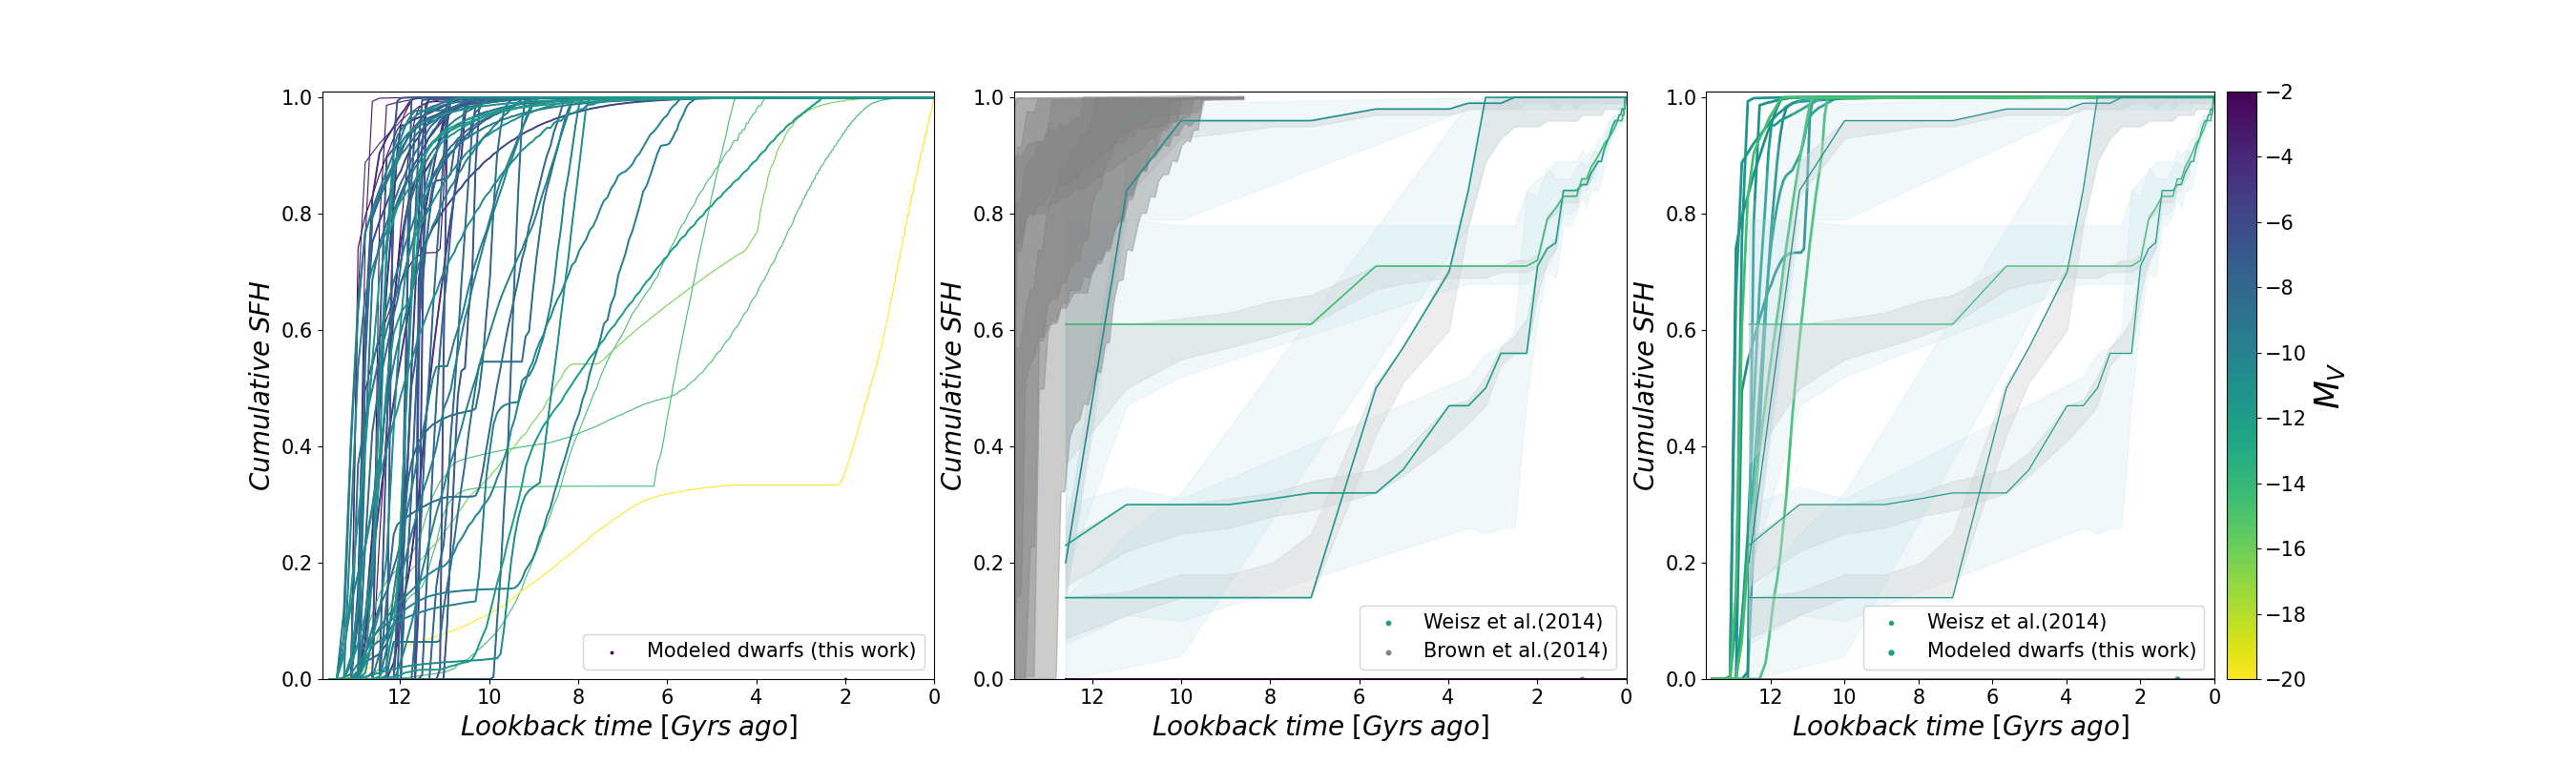

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

In [25]:

from scipy import interpolate
fig2=plt.figure(figsize=(27,8))
ax2=fig2.add_subplot(131)

ax1=fig2.add_subplot(132)
ax3=fig2.add_subplot(133)

plt.subplots_adjust(wspace=0.13, hspace=0)
SFH=[]


cmap = mpl.cm.viridis_r
norm = mpl.colors.Normalize(vmin=-20, vmax=-2)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

        
for sat,color in enumerate(colors):
#     s2=ax2.scatter(lt,sfh_f[sat][0],ls='--',s=1,cmap='plasma',vmin=1,vmax=11,c=np.log10(sfh_cum[sat][0]),label='Disk')
    
    ax2.plot(lt,sfh_f[sat][0],c=color,linewidth=0.8,zorder=0)
    
for sat,color in enumerate(colors_model):
#     s2=ax2.scatter(lt,sfh_f[sat][0],ls='--',s=1,cmap='plasma',vmin=1,vmax=11,c=np.log10(sfh_cum[sat][0]),label='Disk')
    
    ax3.plot(lt,sfh_f[sat][0],c=color,linewidth=2,zorder=0)
    
for sat,color in enumerate(colors_range):
    ax2.plot(lt,sfh_f[obs_range][sat][0],c=color,linewidth=1.4,zorder=0)
      

for i,color1 in enumerate(colors_obs):
#     s2=ax2.scatter(lt,sfh_f[i][0],ls='-',s=0.01,cmap='plasma_r',vmin=1,vmax=11,c=np.log10(sfh_cum[i][0]),label='Disk',alpha=1)
    ax1.fill_between(lbt_obs,sfh_obs_84[i][0],sfh_obs_16[i][0],color='lightgrey',alpha=0.4,zorder=1)
    ax1.fill_between(lbtobs,sfh_obs_84t[i][0],sfh_obs_16t[i][0],color='lightblue',alpha=0.17,zorder=1)
    s2=ax1.plot(lbt_obs,sfh_obs[i][0],c=color1,linewidth=1.2,zorder=1)
    
    ax3.fill_between(lbt_obs,sfh_obs_84[i][0],sfh_obs_16[i][0],color='lightgrey',alpha=0.4,zorder=1)
    ax3.fill_between(lbtobs,sfh_obs_84t[i][0],sfh_obs_16t[i][0],color='lightblue',alpha=0.17,zorder=1)
    ax3.plot(lbt_obs,sfh_obs[i][0],c=color1,linewidth=0.9,zorder=1)
    
ax2.scatter(2,0,s=3,c=colors[1],label='Modeled dwarfs (this work)')

datafiles=['BooI','CVNII','ComBer','Hercules','LeoIV','UMaI']
for text in datafiles:
    #Import data from Brown 2014
    data=np.genfromtxt('/home/sachiwee/observations/SFHsBrown2014/'+text+'.txt',names=True)
    LBT_observed=data['LBT']
    frac_obs=data['frac']

    i=0
    n=-1
    while n==-1:

        if((LBT_observed[i+1]-LBT_observed[i])>5.9):
            n=i
        i=i+1
    xvals=np.arange(8.6,14.4,0.01)

    f_up = interpolate.interp1d(LBT_observed[0:n+1],frac_obs[0:n+1])
    f_d = interpolate.interp1d(LBT_observed[n+1:len(LBT_observed)],frac_obs[n+1:len(LBT_observed)])


    ax1.fill_between(xvals,f_up(xvals),f_d(xvals),color='grey',alpha=0.4,zorder=1)
ax1.scatter(1,0,s=10,c=colors_obs[1],label='Weisz et al.(2014)')
ax3.scatter(1,0,s=8,c=colors_obs[1],label='Weisz et al.(2014)')
ax1.scatter(1,0,s=10,c='grey',label='Brown et al.(2014)')

ax3.scatter(1,0,s=13,c=colors_obs[1],label='Modeled dwarfs (this work)')
cb2 = fig2.colorbar(sm,pad=0.02)

cb2.set_label('$M_V$', rotation=90, fontsize=25)
cb2.ax.tick_params(labelsize=15)

ax2.xaxis.set_tick_params(labelsize=15)
ax2.yaxis.set_tick_params(labelsize=15)

ax1.xaxis.set_tick_params(labelsize=15)
ax1.yaxis.set_tick_params(labelsize=15)

ax3.xaxis.set_tick_params(labelsize=15)
ax3.yaxis.set_tick_params(labelsize=15)
ax2.set_ylim(0,1.01)
ax2.set_xlim(0,13.75)
ax2.invert_xaxis()

ax1.set_ylim(0,1.01)
ax1.set_xlim(0,13.75)
ax1.invert_xaxis()
ax3.set_ylim(0,1.01)
ax3.set_xlim(0,13.75)
ax3.invert_xaxis()

ax2.set_ylabel('$Cumulative\;SFH$',fontsize=20)
ax2.set_xlabel('$Lookback\;time\;[Gyrs\;ago]$',fontsize=20)

ax1.set_ylabel('$Cumulative\;SFH$',fontsize=20)
ax1.set_xlabel('$Lookback\;time\;[Gyrs\;ago]$',fontsize=20)

ax3.set_ylabel('$Cumulative\;SFH$',fontsize=20)
ax3.set_xlabel('$Lookback\;time\;[Gyrs\;ago]$',fontsize=20)
# ax2.xaxis.set_tick_params(np.flip(np.arange(0,14,1)),labelsize=15)
ax2.legend(fontsize=15)
ax1.legend(fontsize=15,loc='lower right')
ax3.legend(fontsize=15,loc='lower right')
fig2.savefig('/media/sachiwee/ArmorATD/MW_testruns/figures_MAC/SFH_satellites2.pdf')

In [ ]:
print(np.shape(t90[msk]),np.shape(d[satellite_mask][mask2]),np.shape(stellar_mass[mask2]))

<IPython.core.display.Javascript object>


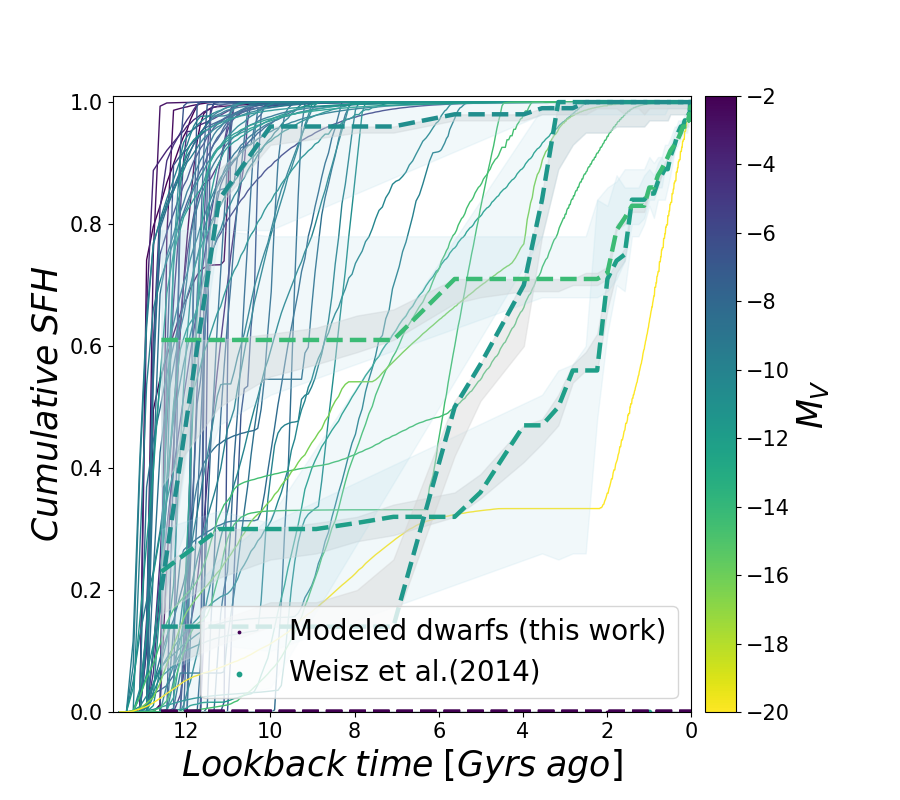

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


In [28]:
fig2=plt.figure(figsize=(9,8))
ax2=fig2.add_subplot(111)


plt.subplots_adjust(wspace=0.13, hspace=0)
SFH=[]


cmap = mpl.cm.viridis_r
norm = mpl.colors.Normalize(vmin=-20, vmax=-2)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

for i,color1 in enumerate(colors_obs):
#     s2=ax2.scatter(lt,sfh_f[i][0],ls='-',s=0.01,cmap='plasma_r',vmin=1,vmax=11,c=np.log10(sfh_cum[i][0]),label='Disk',alpha=1)
    ax2.fill_between(lbt_obs,sfh_obs_84[i][0],sfh_obs_16[i][0],color='lightgrey',alpha=0.4,zorder=1)
    ax2.fill_between(lbtobs,sfh_obs_84t[i][0],sfh_obs_16t[i][0],color='lightblue',alpha=0.17,zorder=1)
    s2=ax2.plot(lbt_obs,sfh_obs[i][0],c=color1,linewidth=3.2,ls='--',zorder=1)
        
for sat,color in enumerate(colors):

    ax2.plot(lt,sfh_f[sat][0],c=color,linewidth=1,zorder=0)
    

    
ax2.scatter(2,0,s=3,c=colors[1],label='Modeled dwarfs (this work)')
ax2.scatter(1,0,s=10,c=colors_obs[1],label='Weisz et al.(2014)')
cb2 = fig2.colorbar(sm,pad=0.02)

cb2.set_label('$M_V$', rotation=90, fontsize=25)
cb2.ax.tick_params(labelsize=15)

ax2.xaxis.set_tick_params(labelsize=15)
ax2.yaxis.set_tick_params(labelsize=15)


ax2.set_ylim(0,1.01)
ax2.set_xlim(0,13.75)
ax2.invert_xaxis()


ax2.set_ylabel('$Cumulative\;SFH$',fontsize=25)
ax2.set_xlabel('$Lookback\;time\;[Gyrs\;ago]$',fontsize=25)

ax2.legend(fontsize=20)

fig2.savefig('/media/sachiwee/ArmorATD/MW_testruns/figures_MAC/SFH_satellites_hubble.pdf')

In [ ]:
infall_t=np.zeros(81)
for sat in range(len(stellar_mass[mask2])):
    for t in range(len(lt)-1):
        if((d[satellite_mask][mask2][sat]<0.350)&(infall_t[sat]==0)):
            print(lt[t])
            infall_t[sat]=lt[t]
            
            

In [65]:
def Mstar_D(t90,Mstar,Mg,hlr):
    '''Plot stellar mass vs tau 90 for MW satellites  '''
    
    fig=plt.figure(figsize=(10,8))
    ax=fig.add_subplot(111)

    fig.patch.set_facecolor('w')


    s1=ax.scatter(t50,Mstar,s=1e5*hlr,cmap='RdYlBu_r',vmin=np.amax(Mg),vmax=np.amin(Mg),c=Mg)

    cb1 = fig.colorbar(s1,pad=0.04)
    cb1.set_label('$M_g$', rotation=90, fontsize=25)
    cb1.ax.tick_params(labelsize=15)

    ax.set_xlim(0,10)
    ax.set_ylim(1e1,1e11)
    
    ax.set_yscale('log')

    ax.set_ylabel('$M_* (z=0)\;[M_{\odot}]$',fontsize=20)
    ax.set_xlabel('$\u03C4_{90}\;[Gyr\;ago]$',fontsize=20)
    leg=ax.legend(fontsize=18,loc='upper left',markerscale=0.01)
    plt.setp(leg.get_texts(), color='w')
    frame = leg.get_frame()

    ax.xaxis.set_tick_params(labelsize=15)
    ax.yaxis.set_tick_params(labelsize=15)

    return fig

<IPython.core.display.Javascript object>


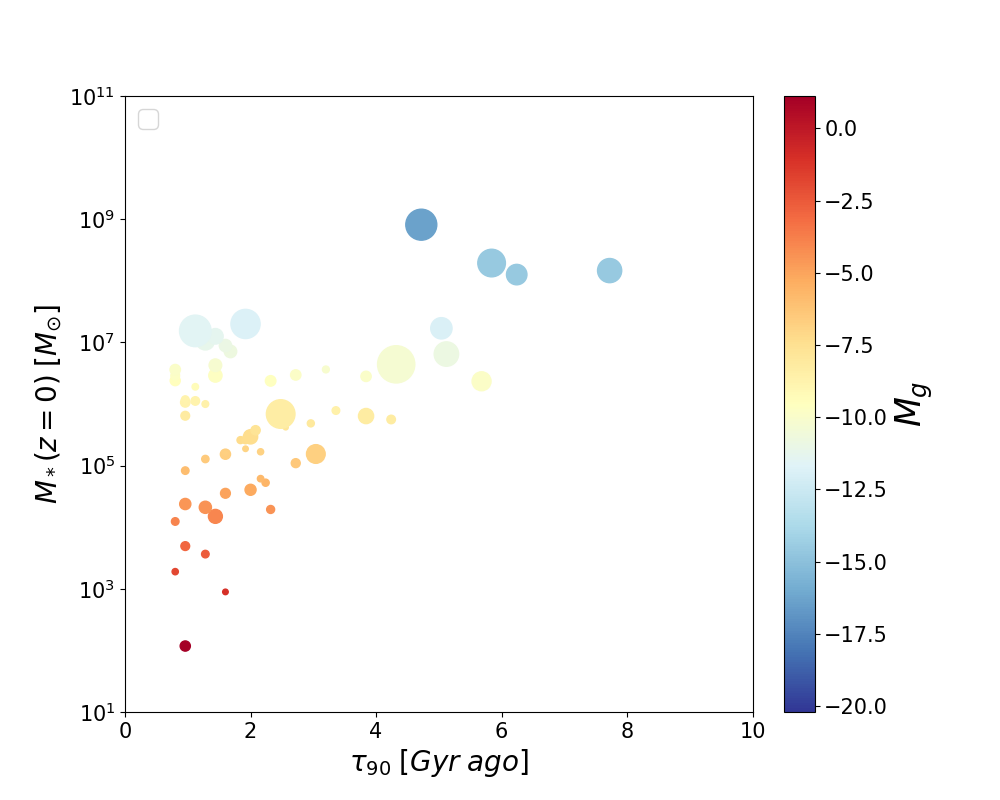

No handles with labels found to put in legend.


In [66]:
fig3=Mstar_D(t90[msk],stellar_mass[order][mask2][msk],Mg[satellite_mask][order][mask2][msk],hlr[mask2][msk])